## Training a differentially private LSTM model for name classification

In this tutorial, we will build a differentially-private LSTM model to classify names to their source languages, which is the same task as in the tutorial **NLP From Scratch** (https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html). Since the objective of this tutorial is to demonstrate the effective use of an LSTM with privacy guarantees, we will be utilizing it in place of the bare-bones RNN model defined in the original tutorial. Specifically, we use the `DPLSTM` module from `opacus.layers.dp_lstm` to facilitate the calculation of the per-example gradients, which are utilized in the addition of noise during the application of differential privacy. `DPLSTM` has the same API and functionality as the `nn.LSTM`, with some restrictions (ex. we currently support single layers, the full list is given below).  

In [63]:
pip install opacus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dataset

First, let us download the dataset of names and their associated language labels as given in https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html. We train our differentially-private LSTM on the same dataset as in that tutorial.

In [64]:
import warnings
warnings.simplefilter("ignore")

import os
import requests


NAMES_DATASET_URL = "https://download.pytorch.org/tutorial/data.zip"
DATA_DIR = "names"

import zipfile
import urllib

def download_and_extract(dataset_url, data_dir):
    print("Downloading and extracting ...")
    filename = "data.zip"

    urllib.request.urlretrieve(dataset_url, filename)
    with zipfile.ZipFile(filename) as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(filename)
    print("Completed!")

download_and_extract(NAMES_DATASET_URL, DATA_DIR)

Completed!


In [65]:
names_folder = os.path.join(DATA_DIR, 'data', 'default_dataset') 
all_filenames = []

for language_file in os.listdir(names_folder):
    all_filenames.append(os.path.join(names_folder, language_file))
    
print(os.listdir(names_folder))

['Egypt.txt', 'Irish.txt', 'Mauritius.txt', 'Russian.txt', 'Chinese.txt', 'Angola.txt', 'US.txt', 'Korean.txt', 'Dutch.txt', 'Estonia.txt', 'Arabic.txt', 'Vietnamese.txt', 'Greek.txt', 'Cyprus.txt', 'albania.txt', 'Haiti.txt', 'Afganisthan.txt', 'Scottish.txt', 'French.txt']


In [66]:
import torch
import torch.nn as nn

class CharByteEncoder(nn.Module):
    """
    This encoder takes a UTF-8 string and encodes its bytes into a Tensor. It can also
    perform the opposite operation to check a result.
    Examples:
    >>> encoder = CharByteEncoder()
    >>> t = encoder('Ślusàrski')  # returns tensor([256, 197, 154, 108, 117, 115, 195, 160, 114, 115, 107, 105, 257])
    >>> encoder.decode(t)  # returns "<s>Ślusàrski</s>"
    """

    def __init__(self):
        super().__init__()
        self.start_token = "<s>"
        self.end_token = "</s>"
        self.pad_token = "<pad>"

        self.start_idx = 256
        self.end_idx = 257
        self.pad_idx = 258

    def forward(self, s: str, pad_to=0) -> torch.LongTensor:
        """
        Encodes a string. It will append a start token <s> (id=self.start_idx) and an end token </s>
        (id=self.end_idx).
        Args:
            s: The string to encode.
            pad_to: If not zero, pad by appending self.pad_idx until string is of length `pad_to`.
                Defaults to 0.
        Returns:
            The encoded LongTensor of indices.
        """
        encoded = s.encode()
        n_pad = pad_to - len(encoded) if pad_to > len(encoded) else 0
        return torch.LongTensor(
            [self.start_idx]
            + [c for c in encoded]  # noqa
            + [self.end_idx]
            + [self.pad_idx for _ in range(n_pad)]
        )

    def decode(self, char_ids_tensor: torch.LongTensor) -> str:
        """
        The inverse of `forward`. Keeps the start, end, and pad indices.
        """
        char_ids = char_ids_tensor.cpu().detach().tolist()

        out = []
        buf = []
        for c in char_ids:
            if c < 256:
                buf.append(c)
            else:
                if buf:
                    out.append(bytes(buf).decode())
                    buf = []
                if c == self.start_idx:
                    out.append(self.start_token)
                elif c == self.end_idx:
                    out.append(self.end_token)
                elif c == self.pad_idx:
                    out.append(self.pad_token)

        if buf:  # in case some are left
            out.append(bytes(buf).decode())
        return "".join(out)

    def __len__(self):
        """
        The length of our encoder space. This is fixed to 256 (one byte) + 3 special chars
        (start, end, pad).
        Returns:
            259
        """
        return 259

## Training / Validation Set Preparation

In [67]:
from torch.nn.utils.rnn import pad_sequence

def padded_collate(batch, padding_idx=0):
    x = pad_sequence(
        [elem[0] for elem in batch], batch_first=True, padding_value=padding_idx
    )
    y = torch.stack([elem[1] for elem in batch]).long()

    return x, y

In [68]:
from torch.utils.data import Dataset
from pathlib import Path


class NamesDataset(Dataset):
    def __init__(self, root):
        self.root = Path(root)

        self.labels = list({langfile.stem for langfile in self.root.iterdir()})
        self.labels_dict = {label: i for i, label in enumerate(self.labels)}
        self.encoder = CharByteEncoder()
        self.samples = self.construct_samples()

    def __getitem__(self, i):
        return self.samples[i]

    def __len__(self):
        return len(self.samples)

    def construct_samples(self):
        samples = []
        for langfile in self.root.iterdir():
            label_name = langfile.stem
            label_id = self.labels_dict[label_name]
            with open(langfile, "r") as fin:
                for row in fin:
                    samples.append(
                        (self.encoder(row.strip()), torch.tensor(label_id).long())
                    )
        return samples

    def label_count(self):
        cnt = Counter()
        for _x, y in self.samples:
            label = self.labels[int(y)]
            cnt[label] += 1
        return cnt


VOCAB_SIZE = 256 + 3  # 256 alternatives in one byte, plus 3 special characters.


We split the dataset into a 80-20 split for training and validation. 

In [69]:
secure_mode = False
train_split = 0.8
test_every = 5
batch_size = 800

ds = NamesDataset(names_folder)
train_len = int(train_split * len(ds))
test_len = len(ds) - train_len

print(f"{train_len} samples for training, {test_len} for testing")

train_ds, test_ds = torch.utils.data.random_split(ds, [train_len, test_len])

17561 samples for training, 4391 for testing


In [70]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    pin_memory=True,
    collate_fn=padded_collate,
)

test_loader = DataLoader(
    test_ds,
    batch_size=2 * batch_size,
    shuffle=False,
    pin_memory=True,
    collate_fn=padded_collate,
)

After splitting the dataset into a training and a validation set, we now have to convert the data into a numeric form suitable for training the LSTM model. For each name, we set a maximum sequence length of 15, and if a name is longer than the threshold, we truncate it (this rarely happens in this dataset!). If a name is smaller than the threshold, we add a dummy `#` character to pad it to the desired length. We also batch the names in the dataset and set a batch size of 256 for all the experiments in this tutorial. The function `line_to_tensor()` returns a tensor of shape [15, 256] where each element is the index (in `all_letters`) of the corresponding character.

## Training/Evaluation Cycle 

The training and the evaluation functions `train()` and `test()` are defined below. During the training loop, the per-example gradients are computed and the parameters are updated subsequent to gradient clipping (to bound their sensitivity) and addition of noise.  

In [71]:
from statistics import mean

def train(model, criterion, optimizer, train_loader, epoch, privacy_engine, device="cuda:0"):
    accs = []
    losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        preds = logits.argmax(-1)
        n_correct = float(preds.eq(y).sum())
        batch_accuracy = n_correct / len(y)

        accs.append(batch_accuracy)
        losses.append(float(loss))

    printstr = (
        f"\t Epoch {epoch}. Accuracy: {mean(accs):.6f} | Loss: {mean(losses):.6f}"
    )
    if privacy_engine:
        epsilon = privacy_engine.get_epsilon(delta)
        printstr += f" | (ε = {epsilon:.2f}, δ = {delta})"

    print(printstr)
    return losses, accs


def test(model, test_loader, privacy_engine, device="cuda:0"):
    accs = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            preds = model(x).argmax(-1)
            n_correct = float(preds.eq(y).sum())
            batch_accuracy = n_correct / len(y)

            accs.append(batch_accuracy)
    printstr = "\n----------------------------\n" f"Test Accuracy: {mean(accs):.6f}"
    if privacy_engine:
        epsilon = privacy_engine.get_epsilon(delta)
        printstr += f" (ε = {epsilon:.2f}, δ = {delta})"
    print(printstr + "\n----------------------------\n")
    return


## Hyper-parameters

There are two sets of hyper-parameters associated with this model. The first are hyper-parameters which we would expect in any machine learning training, such as the learning rate and batch size. The second set are related to the privacy engine, where for example we define the amount of noise added to the gradients (`noise_multiplier`), and the maximum L2 norm to which the per-sample gradients are clipped (`max_grad_norm`). 

In [72]:
# Training hyper-parameters
epochs = 20
learning_rate = 2.0

# Privacy engine hyper-parameters
max_per_sample_grad_norm = 1.5
delta = 8e-5
epsilon = 12.0

## Model

We define the name classification model in the cell below. Note that it is a simple char-LSTM classifier, where the input characters are passed through an `nn.Embedding` layer, and are subsequently input to the DPLSTM. 

In [73]:
import torch
from torch import nn
from opacus.layers import DPLSTM

class CharNNClassifier(nn.Module):
    def __init__(
        self,
        embedding_size,
        hidden_size,
        output_size,
        num_lstm_layers=1,
        bidirectional=False,
        vocab_size=VOCAB_SIZE,
    ):
        super().__init__()

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = DPLSTM(
            embedding_size,
            hidden_size,
            num_layers=num_lstm_layers,
            bidirectional=bidirectional,
            batch_first=True,
        )
        self.out_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # -> [B, T, D]
        x, _ = self.lstm(x, hidden)  # -> [B, T, H]
        x = x[:, -1, :]  # -> [B, H]
        x = self.out_layer(x)  # -> [B, C]
        return x

We now proceed to instantiate the objects (privacy engine, model and optimizer) for our differentially-private LSTM training.  However, the `nn.LSTM` is replaced with a `DPLSTM` module which enables us to calculate per-example gradients. 

In [74]:
# Set the device to run on a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define classifier parameters
embedding_size = 64
hidden_size = 128  # Number of neurons in hidden layer after LSTM
n_lstm_layers = 1
bidirectional_lstm = False

model = CharNNClassifier(
    embedding_size,
    hidden_size,
    len(ds.labels),
    n_lstm_layers,
    bidirectional_lstm,
).to(device)

## Defining the privacy engine, optimizer and loss criterion for the problem

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [76]:
from opacus import PrivacyEngine
privacy_engine = PrivacyEngine(secure_mode=secure_mode)

model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    max_grad_norm=max_per_sample_grad_norm,
    target_delta=delta,
    target_epsilon=epsilon,
    epochs=epochs,
)

## Training the name classifier with privacy

Finally, we can start training! We will be training for 50 epochs iterations (where each epoch corresponds to a pass over the whole dataset). We will be reporting the privacy epsilon every `test_every` epoch. We will also benchmark this differentially-private model against a model without privacy and obtain almost identical performance. Further, the private model trained with Opacus incurs only minimal overhead in training time, with the differentially-private classifier only slightly slower (by a couple of minutes) than the non-private model.

Train stats: 

	 Epoch 0. Accuracy: 0.416466 | Loss: 2.444053 | (ε = 3.51, δ = 8e-05)

----------------------------
Test Accuracy: 0.420713 (ε = 3.51, δ = 8e-05)
----------------------------

	 Epoch 1. Accuracy: 0.430902 | Loss: 2.250197 | (ε = 4.38, δ = 8e-05)
	 Epoch 2. Accuracy: 0.431786 | Loss: 2.228084 | (ε = 5.07, δ = 8e-05)
	 Epoch 3. Accuracy: 0.429215 | Loss: 2.233914 | (ε = 5.67, δ = 8e-05)
	 Epoch 4. Accuracy: 0.421968 | Loss: 2.251166 | (ε = 6.21, δ = 8e-05)
	 Epoch 5. Accuracy: 0.433319 | Loss: 2.151300 | (ε = 6.72, δ = 8e-05)

----------------------------
Test Accuracy: 0.432137 (ε = 6.72, δ = 8e-05)
----------------------------

	 Epoch 6. Accuracy: 0.468195 | Loss: 1.913749 | (ε = 7.19, δ = 8e-05)
	 Epoch 7. Accuracy: 0.480620 | Loss: 1.779941 | (ε = 7.63, δ = 8e-05)
	 Epoch 8. Accuracy: 0.490078 | Loss: 1.721745 | (ε = 8.06, δ = 8e-05)
	 Epoch 9. Accuracy: 0.494772 | Loss: 1.709840 | (ε = 8.47, δ = 8e-05)
	 Epoch 10. Accuracy: 0.493697 | Loss: 1.709075 | (ε = 8.87, δ 

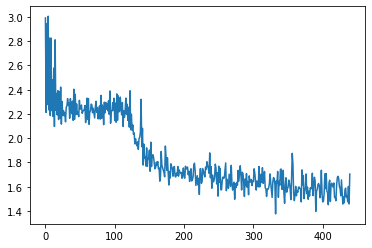

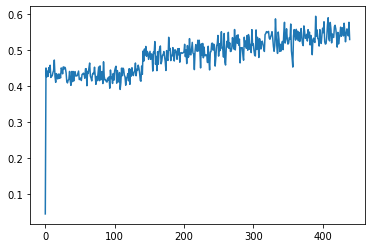

In [77]:
print("Train stats: \n")
all_losses_privacy = []
all_accs_privacy = []

for epoch in range(epochs):
    losses, accs = train(model, criterion, optimizer, train_loader, epoch, privacy_engine, device=device)
    all_losses_privacy.extend(losses)
    all_accs_privacy.extend(accs)
    if test_every:
        if epoch % test_every == 0:
            test(model, test_loader, privacy_engine, device=device)

test(model, test_loader, privacy_engine, device=device)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses_privacy)
plt.figure()
plt.plot(all_accs_privacy)

The differentially-private name classification model obtains a test accuracy of 0.75 with an epsilon of just under 12. This shows that we can achieve good accuracy on this task, with minimal loss of privacy.

## Training the name classifier without privacy

 We also run a comparison with a non-private model to see if the performance obtained with privacy is comparable to it. To do this, we keep the parameters such as learning rate and batch size the same, and only define a different instance of the model along with a separate optimizer.

In [78]:
model_nodp = CharNNClassifier(
    embedding_size,
    hidden_size,
    len(ds.labels),
    n_lstm_layers,
    bidirectional_lstm,
).to(device)


optimizer_nodp = torch.optim.SGD(model_nodp.parameters(), lr=0.5)

	 Epoch 0. Accuracy: 0.413156 | Loss: 2.253569

----------------------------
Test Accuracy: 0.420713
----------------------------

	 Epoch 1. Accuracy: 0.435449 | Loss: 2.172924
	 Epoch 2. Accuracy: 0.423992 | Loss: 2.187024
	 Epoch 3. Accuracy: 0.431383 | Loss: 2.174955
	 Epoch 4. Accuracy: 0.428736 | Loss: 2.170502
	 Epoch 5. Accuracy: 0.425481 | Loss: 2.180156

----------------------------
Test Accuracy: 0.421201
----------------------------

	 Epoch 6. Accuracy: 0.432725 | Loss: 2.167378
	 Epoch 7. Accuracy: 0.427478 | Loss: 2.180849
	 Epoch 8. Accuracy: 0.430790 | Loss: 2.171839
	 Epoch 9. Accuracy: 0.422499 | Loss: 2.186137
	 Epoch 10. Accuracy: 0.429677 | Loss: 2.163712

----------------------------
Test Accuracy: 0.421201
----------------------------

	 Epoch 11. Accuracy: 0.431060 | Loss: 2.161904
	 Epoch 12. Accuracy: 0.431206 | Loss: 2.166213
	 Epoch 13. Accuracy: 0.434833 | Loss: 2.158972
	 Epoch 14. Accuracy: 0.435337 | Loss: 2.146451
	 Epoch 15. Accuracy: 0.436757 | Loss:

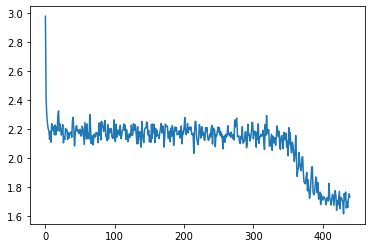

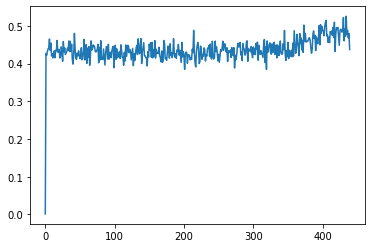

In [79]:
all_losses = []
all_accs = []

for epoch in range(epochs):
    losses, accs = train(model_nodp, criterion, optimizer_nodp, train_loader, epoch, None, device=device)
    all_losses.extend(losses)
    all_accs.extend(accs)
    if test_every:
        if epoch % test_every == 0:
            test(model_nodp, test_loader, None, device=device)

test(model_nodp, test_loader, None, device=device)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.figure()
plt.plot(all_accs)

We run the training loop again, this time without privacy and for the same number of iterations. 

The non-private classifier obtains a test accuracy of around 0.75 with the same parameters and number of epochs. We are effectively trading off performance on the name classification task for a lower loss of privacy.